Đang tải no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

Đang tải glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

Đang tải meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

Đang tải pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Số lượng hình ảnh: 4237, Số lượng nhãn: 4237


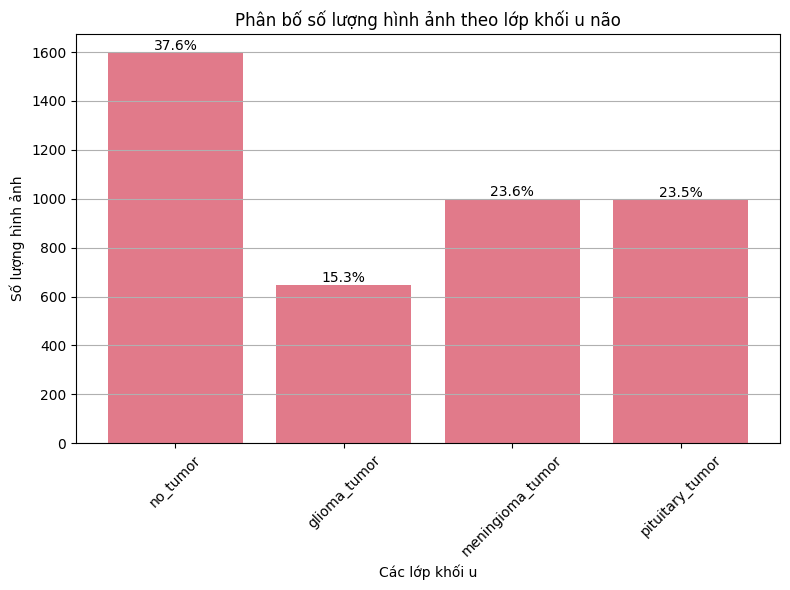

Kích thước tập đặc trưng: (69419008, 3)
Kích thước tập đặc trưng sau chuẩn hóa: (69419008, 3)


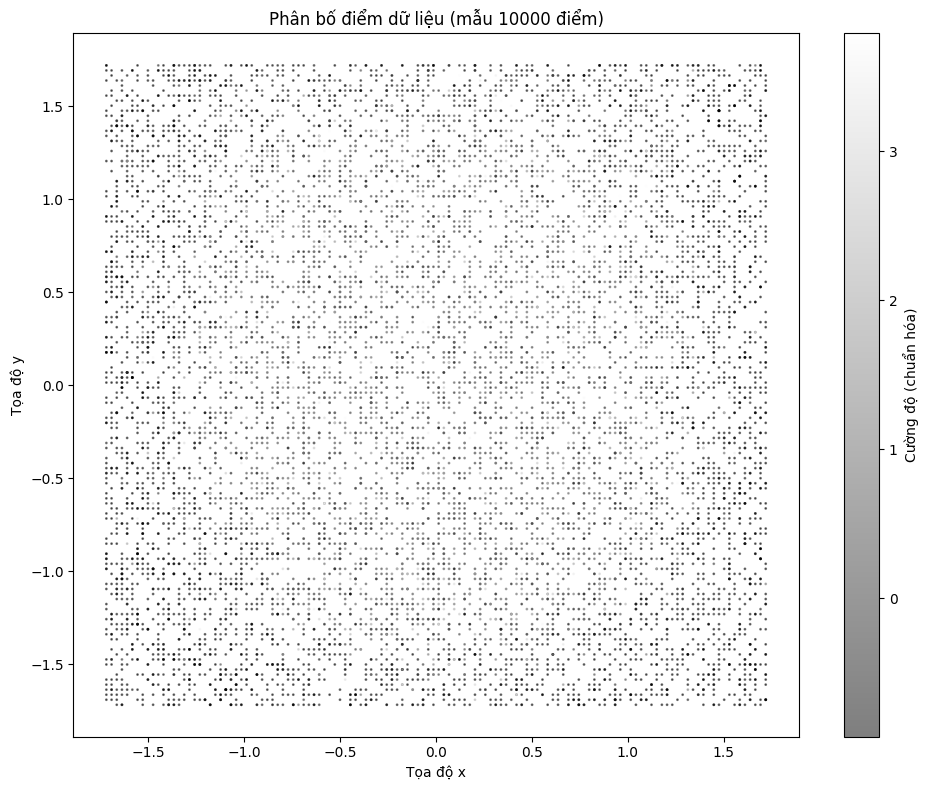

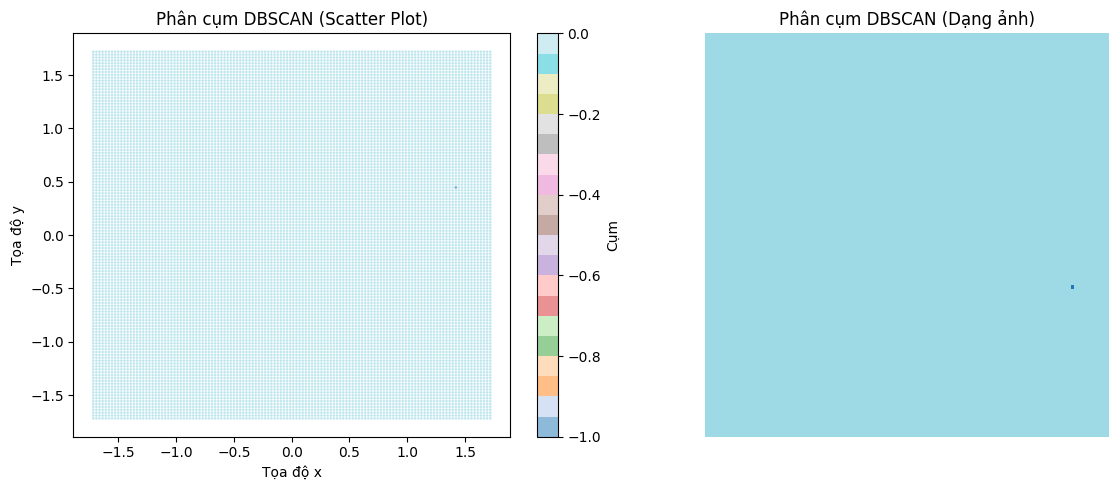

'\nPhần tiền xử lý và phân cụm DBSCAN kết thúc tại đây.\n'

In [1]:
"""
Tiền xử lý dữ liệu cho DBSCAN - Phân đoạn khối u não
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

"""
Bộ dữ liệu này bao gồm 4237 hình ảnh IRM của các khối u não, được sử dụng để phân đoạn khối u não dựa trên hình ảnh chụp cộng hưởng từ (MRI).
Chỉ sử dụng tập 'image' cho DBSCAN (không cần mặt nạ vì DBSCAN là không giám sát).

Dataset source: https://www.sciencedirect.com/science/article/pii/S095741742302849X#tbl3

Image:
* 0 (No Tumor, 1595 images),
* 1 (Glioma, 649 images),
* 2 (Meningioma, 999 images),
* 3 (Pituitary, 994 images),
"""

# Đường dẫn truy cập dữ liệu
data_path = "Brain Tumor Segmentation Dataset"
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
images = []
labels = []
target_size = (128, 128)

# Bước 1: Tải hình ảnh
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    
    if os.path.exists(image_folder):
        for image_name in tqdm(os.listdir(image_folder), desc=f"Đang tải {class_name}"):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)  # Thay đổi kích thước hình ảnh
                image = image / 255.0  # Chuẩn hóa giá trị pixel về [0, 1]
                
                images.append(image)
                labels.append(classes.index(class_name))

# Chuyển đổi danh sách thành mảng NumPy
images = np.array(images)  # Shape: (4237, 128, 128)
labels = np.array(labels)  # Shape: (4237,)

print(f"Số lượng hình ảnh: {len(images)}, Số lượng nhãn: {len(labels)}")

# Bước 2: Kiểm tra trực quan - Phân bố dữ liệu
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')
plt.xlabel('Các lớp khối u')
plt.ylabel("Số lượng hình ảnh")
plt.title("Phân bố số lượng hình ảnh theo lớp khối u não")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Bước 3: Vector hóa và tạo đặc trưng
def vectorize_image(image):
    """
    Chuyển một ảnh thành tập hợp các điểm dữ liệu với đặc trưng: cường độ, tọa độ x, tọa độ y.
    """
    h, w = image.shape
    intensity = image.flatten()  # Giá trị cường độ pixel
    x, y = np.meshgrid(np.arange(w), np.arange(h))  # Tạo lưới tọa độ
    x = x.flatten()
    y = y.flatten()
    features = np.column_stack((intensity, x, y))  # Shape: (16384, 3) với 16384 = 128 * 128
    return features

# Vector hóa tất cả ảnh
image_features = [vectorize_image(img) for img in images]
all_features = np.vstack(image_features)  # Shape: (4237 * 16384, 3) = (69368368, 3)
print(f"Kích thước tập đặc trưng: {all_features.shape}")

# Bước 4: Chuẩn hóa đặc trưng
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)  # Chuẩn hóa về mean=0, std=1
print(f"Kích thước tập đặc trưng sau chuẩn hóa: {all_features_scaled.shape}")

# Bước 5: Kiểm tra trực quan - Phân bố điểm dữ liệu
def plot_feature_distribution(features, sample_size=10000):
    """
    Vẽ scatter plot của một mẫu điểm dữ liệu để kiểm tra phân bố.
    """
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        sample_features = features[indices]
    else:
        sample_features = features
    
    plt.figure(figsize=(10, 8))
    plt.scatter(sample_features[:, 1], sample_features[:, 2], c=sample_features[:, 0], cmap='gray', s=1, alpha=0.5)
    plt.colorbar(label='Cường độ (chuẩn hóa)')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    plt.title(f"Phân bố điểm dữ liệu (mẫu {sample_size} điểm)")
    plt.tight_layout()
    plt.show()

plot_feature_distribution(all_features_scaled)

# Bước 6: Áp dụng DBSCAN (ví dụ với một ảnh để giảm tải tính toán)
# Lấy đặc trưng của ảnh đầu tiên để thử nghiệm
single_image_features = vectorize_image(images[0])  # Shape: (16384, 3)
single_image_features_scaled = scaler.transform(single_image_features)  # Chuẩn hóa

dbscan = DBSCAN(eps=0.5, min_samples=10)  # Tham số eps và min_samples cần điều chỉnh
clusters = dbscan.fit_predict(single_image_features_scaled)

# Bước 7: Kiểm tra trực quan - Kết quả phân cụm cho một ảnh
def plot_clusters(features, clusters, image_shape=(128, 128)):
    """
    Vẽ kết quả phân cụm dưới dạng ảnh và scatter plot.
    """
    # Tạo ảnh phân cụm
    cluster_image = clusters.reshape(image_shape)
    
    # Scatter plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(features[:, 1], features[:, 2], c=clusters, cmap='tab20', s=1, alpha=0.5)
    plt.colorbar(label='Cụm')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    plt.title("Phân cụm DBSCAN (Scatter Plot)")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cluster_image, cmap='tab20')
    plt.axis('off')
    plt.title("Phân cụm DBSCAN (Dạng ảnh)")
    
    plt.tight_layout()
    plt.show()

plot_clusters(single_image_features_scaled, clusters)

# (Tùy chọn) Áp dụng DBSCAN cho toàn bộ tập dữ liệu
# Lưu ý: Cần máy tính mạnh hoặc giảm kích thước dữ liệu vì all_features_scaled rất lớn
# dbscan_full = DBSCAN(eps=0.5, min_samples=10)
# clusters_full = dbscan_full.fit_predict(all_features_scaled)

"""
Phần tiền xử lý và phân cụm DBSCAN kết thúc tại đây.
"""